In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3  # Change to InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Use GlobalAveragePooling2D instead of Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
    print(root, folders)

/kaggle/input ['mp-2-resize']
/kaggle/input/mp-2-resize ['CleanDataset']
/kaggle/input/mp-2-resize/CleanDataset ['Resized_Images']
/kaggle/input/mp-2-resize/CleanDataset/Resized_Images []


In [3]:
df = pd.read_csv('/kaggle/input/mp-2-resize/CleanDataset/clean_and_merged_df.csv')

# Define the image directory
image_dir = '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images'

In [4]:
# Append the full path to imageid column
df['imageid'] = df['imageid'].apply(lambda x: os.path.join(image_dir, x))

In [5]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['glaucoma'], random_state=42)

In [6]:
# Rename 'glaucoma' column to 'target' in both dataframes
train_df.rename(columns={'glaucoma': 'target'}, inplace=True)
val_df.rename(columns={'glaucoma': 'target'}, inplace=True)

In [7]:
# Update the labels to 'normal' for 0 and 'glaucoma' for 1
train_df['target'] = train_df['target'].replace({0: 'normal', 1: 'glaucoma'})
val_df['target'] = val_df['target'].replace({0: 'normal', 1: 'glaucoma'})

In [8]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define your target classes
class_mapping = {'normal': 0, 'glaucoma': 1}

# Create training and validation data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='imageid',
    y_col='target',
    target_size=(299, 299),  # InceptionV3 expects 299x299 images
    batch_size=32,
    class_mode='binary',
    classes=list(class_mapping.keys())
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='imageid',
    y_col='target',
    target_size=(299, 299),  # InceptionV3 expects 299x299 images
    batch_size=32,
    class_mode='binary',
    classes=list(class_mapping.keys())
)

Found 2056 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


In [9]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'normal': 0, 'glaucoma': 1}
{'normal': 0, 'glaucoma': 1}


In [10]:
# Function to print all information of a generator
def print_generator_info(generator, name='Generator'):
    print(f"\nInformation for {name}:")
    print(f"Class Indices: {generator.class_indices}")  # Class labels and their corresponding indices
    print(f"Classes: {generator.classes[:10]}")  # Display the first 10 class labels (encoded as integers)
    print(f"Batch Size: {generator.batch_size}")  # Batch size used in the generator
    print(f"Image Shape: {generator.image_shape}")  # Shape of the images fed into the model
    print(f"Total Samples: {generator.samples}")  # Total number of samples in the generator
    print(f"Steps Per Epoch: {generator.n}")  # Number of steps (batches) per epoch
    print(f"Target Size: {generator.target_size}")  # Target size of the images after resizing
    print(f"Color Mode: {generator.color_mode}")  # Color mode (e.g., 'rgb', 'grayscale')
    print(f"Shuffle: {generator.shuffle}")  # Whether the data is shuffled
    print(f"First 5 File Paths: {generator.filepaths[:5]}")  # First 5 file paths of the images


# Print information for both train_generator and val_generator
print_generator_info(train_generator, name='Train Generator')
print_generator_info(val_generator, name='Validation Generator')


# Print total number of images in train and validation generators
print(f"Total images in train_generator: {train_generator.samples}")
print(f"Total images in val_generator: {val_generator.samples}")


Information for Train Generator:
Class Indices: {'normal': 0, 'glaucoma': 1}
Classes: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Batch Size: 32
Image Shape: (299, 299, 3)
Total Samples: 2056
Steps Per Epoch: 2056
Target Size: (299, 299)
Color Mode: rgb
Shuffle: True
First 5 File Paths: ['/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2695.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_1165.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_1034.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_953.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/n0096.jpg']

Information for Validation Generator:
Class Indices: {'normal': 0, 'glaucoma': 1}
Classes: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Batch Size: 32
Image Shape: (299, 299, 3)
Total Samples: 515
Steps Per Epoch: 515
Target Size: (299, 299)
Color Mode: rgb
Shuffle: True
First 5 File Paths: ['/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2035.jpg', '/kaggle/input/mp

In [11]:
# Step 1: Load the InceptionV3 model with pre-trained ImageNet weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Step 2: Fine-tuning - Unfreeze some layers of the InceptionV3 base model
# Unfreeze the last few convolutional blocks of the InceptionV3 model
for layer in base_model.layers[:109]:
    layer.trainable = False
for layer in base_model.layers[109:]:
    layer.trainable = True

# Define the model by adding custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)  # GlobalAveragePooling2D instead of Flatten
x = Dense(1, activation='sigmoid')(x)  # For binary classification

model = Model(inputs=base_model.input, outputs=x)

# Step 3: Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 19,202,177 (73.25 MB)

 Non-trainable params: 2,602,656 (9.93 MB)

In [13]:
# [train the model]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [15]:
# Train the entire model again, with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=50,  # Fine-tune for more epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7419 - loss: 0.5766 - val_accuracy: 0.7612 - val_loss: 0.5539 - learning_rate: 1.0000e-05
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 627ms/step - accuracy: 0.8011 - loss: 0.4933 - val_accuracy: 0.7650 - val_loss: 0.5164 - learning_rate: 1.0000e-05
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 618ms/step - accuracy: 0.7946 - loss: 0.4569 - val_accuracy: 0.7728 - val_loss: 0.4773 - learning_rate: 1.0000e-05
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 618ms/step - accuracy: 0.7923 - loss: 0.4514 - val_accuracy: 0.7864 - val_loss: 0.4532 - learning_rate: 1.0000e-05
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 44s 613ms/step - accuracy: 0.8077 - loss: 0.4318 - val_accuracy: 0.7903 - val_loss: 0.4378 - learning_rate: 1.0000e-05
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 622ms/step - accuracy: 0.8116 - loss: 0.4110 - val_accuracy: 0.7903 - val_loss: 0.4305 - learning_rate: 1.0000e-05
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 617ms/step - accura

In [16]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss after fine-tuning: {loss}')
print(f'Validation Accuracy after fine-tuning: {accuracy}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8138 - loss: 0.4029
Validation Loss after fine-tuning: 0.4208591878414154
Validation Accuracy after fine-tuning: 0.7961165308952332


In [17]:
# Get predictions for the validation set
y_pred_probs = model.predict(val_generator)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = val_generator.classes  # True classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 404ms/step


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Get predictions
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.round(y_pred_probs).astype(int)  # For binary classification

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
Precision: 0.21
Recall: 0.13
F1 Score: 0.16


In [20]:
# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       392
           1       0.21      0.13      0.16       123

    accuracy                           0.67       515
   macro avg       0.48      0.49      0.48       515
weighted avg       0.62      0.67      0.64       515



In [21]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[330  62]
 [107  16]]


In [22]:
from sklearn.metrics import roc_auc_score

# No need to slice, just use y_pred_probs directly
auc_roc = roc_auc_score(y_true_classes, y_pred_probs)  # y_pred_probs is already (n_samples,)
print(f'AUC-ROC: {auc_roc:.2f}')

AUC-ROC: 0.46


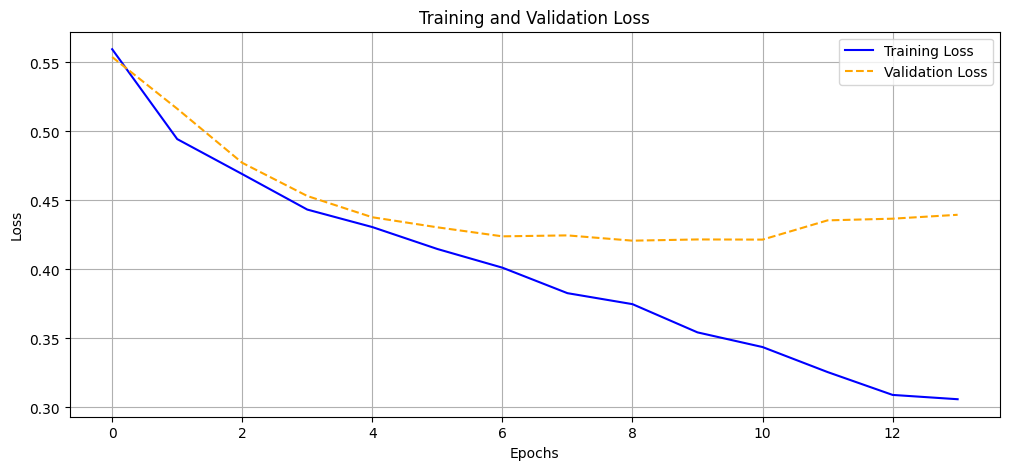

In [23]:
# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))

# Training Loss
plt.plot(history_finetune.history['loss'], label='Training Loss', color='blue', linestyle='-')
# Validation Loss
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training Accuracy
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
# Validation Accuracy
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/kaggle/working/MP_InceptionV3-FineTuning.h5')